In [10]:
import pandas as pd
import os
#
# Пути к файлам и соответствующие названия колонок
file_paths = {
    'bert': '/bert/sim-words5-bert.csv',
    'glove': '/glove_python/sim-words10-glove.csv',
    'pmi': '/pmi/similar_words_pmi.csv',
    'word2vec': '/word2vec/similar_words10.csv'
}

# Создаем пустой DataFrame с колонкой 'word'
data = {}

# Обрабатываем каждый файл
for model_name, path in file_paths.items():
    # Читаем CSV-файл
    full_path = ".." + path
    df = pd.read_csv(full_path)
    
    # Добавляем данные в основной DataFrame
    data[model_name] = df

In [11]:
from gensim.models import KeyedVectors, Word2Vec

# Загрузка эталонной модели
thesaurus = KeyedVectors.load_word2vec_format("thesaurus.w2v", binary=True, unicode_errors='ignore')
# thesaurus = Word2Vec.load("thesaurus.w2v", encoding='latin1')

In [12]:
import numpy as np
from tqdm import tqdm  # для прогресс-бара

def compare_with_thesaurus(model_words, model_similarities, thesaurus, topn=10):
    """
    Сравнивает модель с тезаурусом
    
    Args:
        model_words: список слов из модели (ваши 'Word' столбцы)
        model_similarities: соответствующие списки похожих слов и весов
        thesaurus: эталонная модель
        topn: сколько топовых слов сравнивать
    
    Returns:
        dict: метрики сравнения
    """
    total_similarity = 0
    found_words = 0
    valid_pairs = 0
    
    for word, sim_data in tqdm(zip(model_words, model_similarities), total=len(model_words)):
        if word not in thesaurus:
            print(word)
            continue
            
        found_words += 1
        model_top = [w for w, _ in sim_data[:topn]] if sim_data else []
        
        try:
            thesaurus_top = [w for w, _ in thesaurus.most_similar(word, topn=topn)]
            
            # Вычисляем пересечение
            common = set(model_top) & set(thesaurus_top)
            total_similarity += len(common) / topn
            valid_pairs += 1
        except KeyError:
            continue
    
    metrics = {
        'coverage': found_words / len(model_words),
        'avg_overlap': total_similarity / valid_pairs if valid_pairs else 0,
        'total_words': len(model_words),
        'matched_words': found_words,
        'valid_pairs': valid_pairs
    }
    return metrics

In [14]:
results = {}

for (model_name, df) in data.items():
    print(f"\nProcessing {model_name}...")
    
    # Преобразование строк в списки (если нужно)
    df['Most_Similar_Word'] = df['Most_Similar_Word'].apply(
        lambda x: eval(x) if isinstance(x, str) else x
    )
    
    # Фильтрация пустых значений
    valid_data = df.dropna(subset=['Most_Similar_Word'])
    valid_data = valid_data[valid_data['Most_Similar_Word'].apply(len) > 0]
    
    # Сравнение с тезаурусом
    metrics = compare_with_thesaurus(
        valid_data['Word'].tolist(),
        valid_data['Most_Similar_Word'].tolist(),
        thesaurus,
        topn=10
    )
    
    results[model_name] = metrics


Processing bert...


  0%|          | 0/39145 [00:00<?, ?it/s]c:\Users\vadim\scoop\apps\python\3.12.6\Lib\site-packages\gensim\models\keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
100%|██████████| 39145/39145 [14:41<00:00, 44.40it/s] 



Processing glove...


  0%|          | 0/26062 [00:00<?, ?it/s]c:\Users\vadim\scoop\apps\python\3.12.6\Lib\site-packages\gensim\models\keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
100%|██████████| 26062/26062 [13:39<00:00, 31.80it/s]



Processing pmi...


  0%|          | 0/38350 [00:00<?, ?it/s]c:\Users\vadim\scoop\apps\python\3.12.6\Lib\site-packages\gensim\models\keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
100%|██████████| 38350/38350 [15:24<00:00, 41.50it/s] 



Processing word2vec...


  0%|          | 0/71192 [00:00<?, ?it/s]c:\Users\vadim\scoop\apps\python\3.12.6\Lib\site-packages\gensim\models\keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
100%|██████████| 71192/71192 [31:10<00:00, 38.07it/s] 


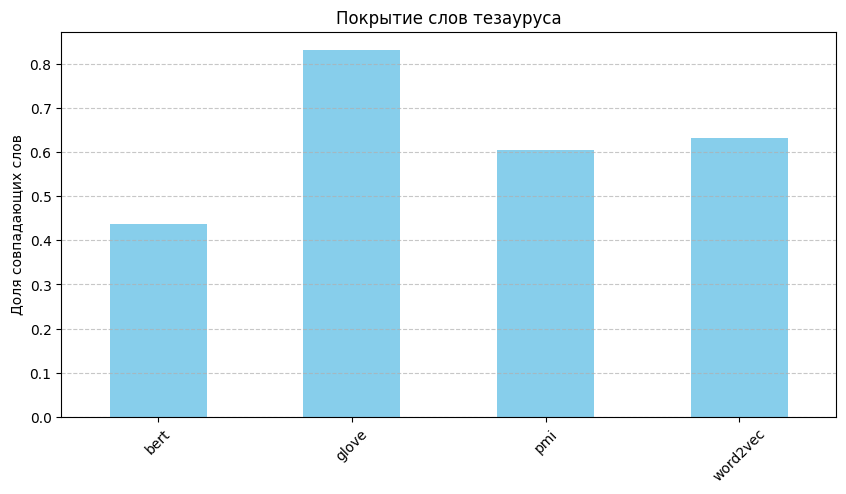

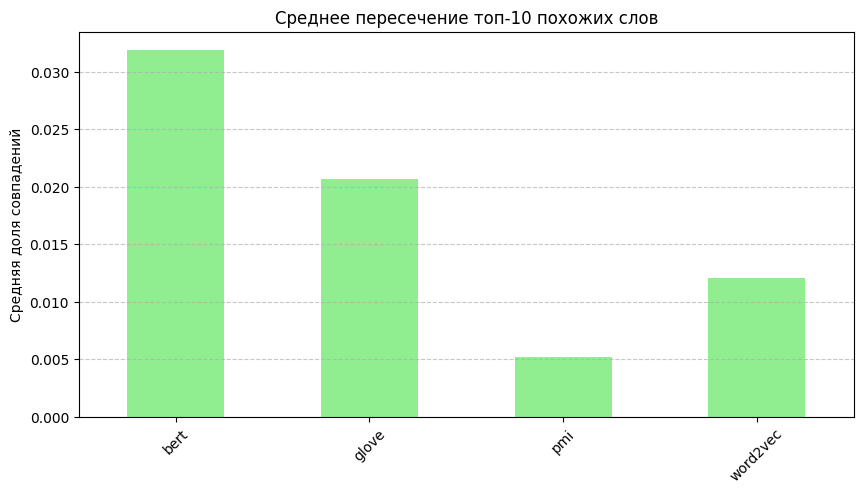

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results).T

# График покрытия
plt.figure(figsize=(10, 5))
results_df['coverage'].plot(kind='bar', color='skyblue')
plt.title('Покрытие слов тезауруса')
plt.ylabel('Доля совпадающих слов')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# График среднего пересечения
plt.figure(figsize=(10, 5))
results_df['avg_overlap'].plot(kind='bar', color='lightgreen')
plt.title('Среднее пересечение топ-10 похожих слов')
plt.ylabel('Средняя доля совпадений')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

## Соединение запросов от LLM и простых запросов (заголовок + весь текст)

In [3]:
import dask.dataframe as dd

llm_query = dd.read_csv("../llm-query-csv/*.part")
simple_query = dd.read_parquet("query.pq")

merged = simple_query.merge(
    llm_query,
    on=['News_Id', 'News_Title', 'News_Text'],
    how='left',
    suffixes=('_simple', '_llm')
)

def combine_queries(row):
    if isinstance(row['News_Query_llm'], list):
        return row['News_Query_simple'] + row['News_Query_llm']
    else:
        return row['News_Query_simple']

merged['News_Query'] = merged.apply(
    combine_queries,
    axis=1,
    meta=('News_Query', 'object')
)

result = merged[['News_Id', 'News_Title', 'News_Text', 'News_Query']]

c:\Users\vadim\Desktop\6 sem\Курсовая\.venv\Lib\site-packages\dask\dataframe\multi.py:169: UserWarning: Merging dataframes with merge column data type mismatches: 
+------------------------+------------+-------------+
| Merge columns          | left dtype | right dtype |
+------------------------+------------+-------------+
| ('News_Id', 'News_Id') | int32      | int64       |
+------------------------+------------+-------------+
Cast dtypes explicitly to avoid unexpected results.
  warnings.warn(


In [6]:
print(len(result))
print(len(simple_query))
print(len(llm_query))


31077
31077
312


In [ ]:
result.to_csv("query-combined.csv", index=False)